In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import urllib
import tqdm

In [2]:
data_regions = ["CA", "DE", "FR", "GB", "IN", "JP", "KR", "MX", "RU", "US"]
data_types = ["_category_id.json", "videos.csv"]
data_dir = "./data/"
img_dir = "./img_temp/"
cur_dir = os.getcwd()
columns = ["video_id", "title", "description", "tags", "category_id", "channel_title",
           "publish_time", "trending_date", "views", "likes", "dislikes", "comment_count",
           "comments_disabled", "ratings_disabled", "video_error_or_removed", "thumbnail_link"]

In [3]:
def load_one_image(url, region, idx):
    img_name = "img_{}_{}.jpg".format(region, idx)
    local_path = os.path.join(cur_dir, img_dir, img_name)
    if os.path.isfile(local_path):
        return local_path
    try:
        urllib.request.urlretrieve(url, os.path.join(img_dir, img_name))
    except urllib.error.HTTPError:
        return url
    return local_path

In [4]:
def collect_categories():
    global categories
    categories = {}
    for region in data_regions:
        with open(data_dir + region + data_types[0]) as file:
            cats = json.loads(file.read())
        for item in cats["items"]:
            k, v = int(item["id"]), item["snippet"]["title"]
            if k in categories and categories[k] != v:
                print("ERROR: Category: " + str(k) + ", values: " + categories[k] + " and " + v)
            categories[k] = v

In [5]:
def read_data(region, load_images = False):
    print(region)
    str_region = region
    if isinstance(region, int):
        str_region = data_regions[region]
    videos = pd.read_csv(data_dir + str_region + data_types[1],
                         parse_dates=["publish_time"])[columns]
    uniq = videos.category_id.apply(lambda x: x if x not in categories else -1).unique()
    if len(uniq) == 1:
        videos.category_id = videos.apply(lambda x: categories[x.category_id], axis=1)
    else:
        print("ERROR: No category with ids " + str(uniq))

    videos.trending_date = pd.to_datetime(videos.trending_date, format="%y.%d.%m")

    videos.insert(7, "publish_date", pd.to_datetime(videos['publish_time']).dt.date)
    videos.publish_time = pd.to_datetime(videos['publish_time']).dt.time

    if load_images:
        with tqdm.tqdm(total=videos.shape[0]) as pbar:
            videos.thumbnail_link = videos.apply(lambda x: (load_one_image(x.thumbnail_link, str_region, x.name),
                                                            pbar.update(1)), axis=1)
    return videos

In [6]:
collect_categories()
videos = {reg: read_data(reg) for reg in data_regions}

print(videos["GB"].dtypes)
print(videos["GB"].shape)
videos["GB"].head()

CA
DE
FR
GB
IN
JP
KR
MX
RU
US
video_id                          object
title                             object
description                       object
tags                              object
category_id                       object
channel_title                     object
publish_time                      object
publish_date                      object
trending_date             datetime64[ns]
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
comments_disabled                   bool
ratings_disabled                    bool
video_error_or_removed              bool
thumbnail_link                    object
dtype: object
(38916, 17)


,video_id,title,description,tags,category_id,channel_title,publish_time,publish_date,trending_date,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,thumbnail_link
0,Jw1Y-zhQURU,John Lewis Christmas Ad 2017 - #MozTheMonster,Click here to continue the story and make your...,"christmas|""john lewis christmas""|""john lewis""|...",Howto & Style,John Lewis,07:38:29,2017-11-10,2017-11-14,7224515,55681,10247,9479,False,False,False,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg
1,3s1rvMFUweQ,Taylor Swift: …Ready for It? (Live) - SNL,Musical guest Taylor Swift performs …Ready for...,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",Entertainment,Saturday Night Live,06:24:44,2017-11-12,2017-11-14,1053632,25561,2294,2757,False,False,False,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg
2,n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,Eminem's new track Walk on Water ft. Beyoncé i...,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",Music,EminemVEVO,17:00:03,2017-11-10,2017-11-14,17158579,787420,43420,125882,False,False,False,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg
3,PUTEiSjKwJU,Goals from Salford City vs Class of 92 and Fri...,Salford drew 4-4 against the Class of 92 and F...,"Salford City FC|""Salford City""|""Salford""|""Clas...",Sports,Salford City Football Club,02:30:38,2017-11-13,2017-11-14,27833,193,12,37,False,False,False,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg
4,rHwDegptbI4,Dashcam captures truck's near miss with child ...,Dashcam captures truck's near miss with child ...,[none],News & Politics,Cute Girl Videos,01:45:13,2017-11-13,2017-11-14,9815,30,2,30,False,False,False,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg


In [7]:
videos["GB"][videos["GB"].video_id == "--uXQQ0h-yQ"].loc[:, "trending_date":"comment_count"]

,trending_date,views,likes,dislikes,comment_count
8327,2017-12-25,24723,216,3,10
8522,2017-12-26,26299,234,3,11
8730,2017-12-27,27022,235,3,11
8938,2017-12-28,27413,241,3,11
9145,2017-12-29,27689,243,3,11
9352,2017-12-30,27952,249,3,12
9574,2017-12-31,28251,250,3,12
9776,2018-01-01,28544,252,3,12
9984,2018-01-02,28725,253,3,12


In [8]:
for region in data_regions:
    nones = videos[region][videos[region].tags == "[none]"].title.count()
    all = videos[region].title.count()
    print(region + ": " + str(nones) + " of " + str(all) + " is " + str("%.2f" % float(100 * nones / all)) + "%")

CA: 2385 of 40881 is 5.83%
DE: 3031 of 40840 is 7.42%
FR: 5304 of 40724 is 13.02%
GB: 2010 of 38916 is 5.16%
IN: 1381 of 37352 is 3.70%
JP: 3200 of 20523 is 15.59%
KR: 7183 of 34567 is 20.78%
MX: 7685 of 40451 is 19.00%
RU: 3984 of 40739 is 9.78%
US: 1535 of 40949 is 3.75%


<AxesSubplot:>

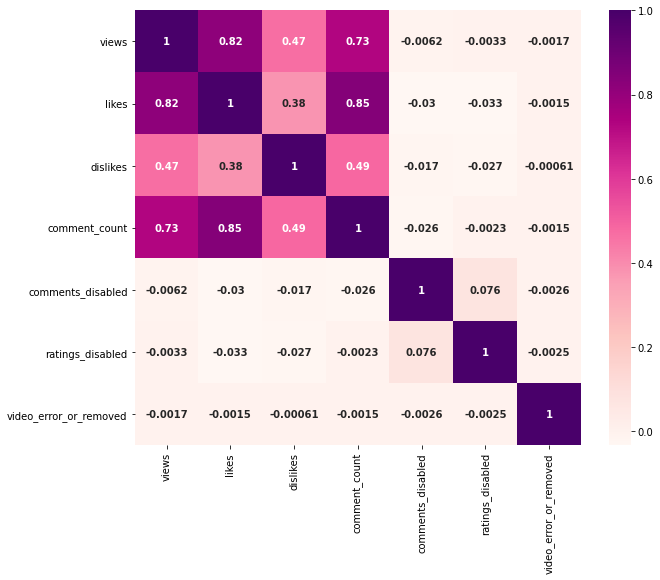

In [9]:
corr = videos["RU"].corr()
fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels = corr.columns,
            yticklabels = corr.columns,
            annot = True,
            cmap="RdPu",
            annot_kws={"weight":"bold"})

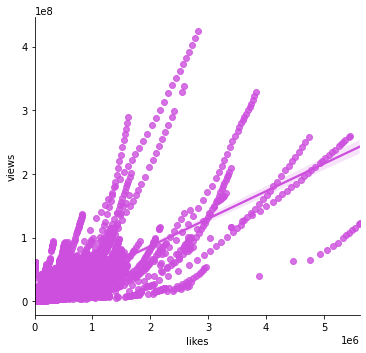

In [10]:
sns.set_palette(sns.color_palette(["#CD4FDE"]))
sns.lmplot(x="likes", y="views", data = videos["GB"])

<AxesSubplot:xlabel='trending_date', ylabel='views'>

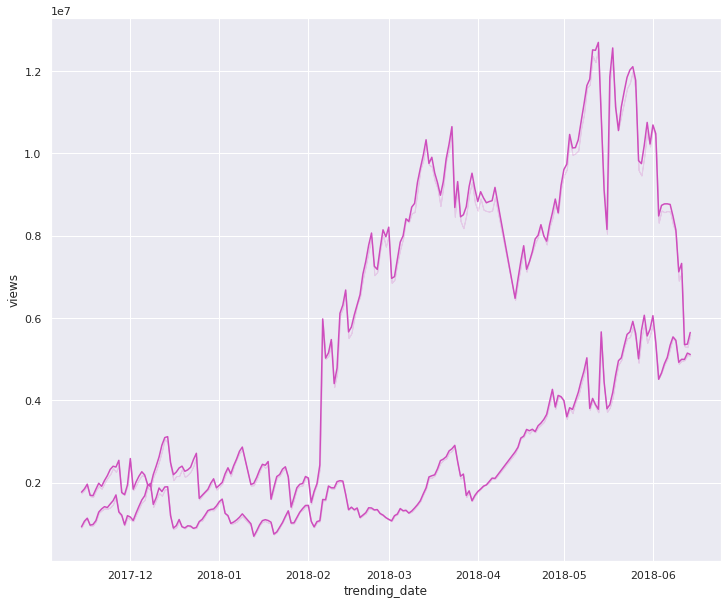

In [11]:
sns.set(rc={"figure.figsize":(12,10)})
ax = sns.lineplot(x="trending_date", y="views", data=videos["US"], ci=False, color="#CE4DBD")
sns.lineplot(x="trending_date", y="views", data=videos["GB"], ci=False, color="#CE4DBD", ax=ax)

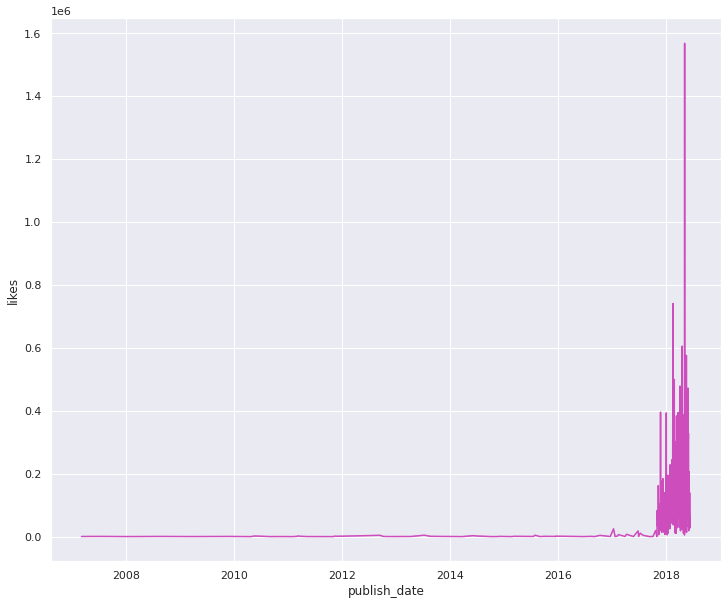

In [13]:
sns.set(rc={"figure.figsize":(12,10)})
ax = sns.lineplot(x="publish_date", y="likes", data=videos["GB"], ci=False, color="#CE4DBD")

In [14]:
videos["GB"][videos["GB"].likes == 0].trending_date.nunique()

175

In [15]:
videos["GB"].trending_date.nunique()

205

In [16]:
videos["GB"].nunique()

video_id                   3272
title                      3369
description                3704
tags                       3122
category_id                  16
channel_title              1625
publish_time               2425
publish_date                300
trending_date               205
views                     38393
likes                     30556
dislikes                  11092
comment_count             15778
comments_disabled             2
ratings_disabled              2
video_error_or_removed        2
thumbnail_link             3272
dtype: int64

In [17]:
videos["GB"].isna().sum()

video_id                    0
title                       0
description               612
tags                        0
category_id                 0
channel_title               0
publish_time                0
publish_date                0
trending_date               0
views                       0
likes                       0
dislikes                    0
comment_count               0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
thumbnail_link              0
dtype: int64